This proct is about to implement a pytorch code to desing a neural network in order to do classification based on the dataset **FasionMNIST**.

The first step then is to download the training and test sets of the dataset using the module **datasets** in pytorch. 

In [1]:
import torch
import torch.nn as nn
import numpy as np
from torchvision import datasets , transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(0.5,0.5)])
#transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x/255)])
train_set = datasets.FashionMNIST('.\FasionMNIST' , download = True , train = True, transform=transform)
test_set = datasets.FashionMNIST('.\FashioMNIST' , download = True , train = False, transform = transforms.ToTensor())

Also, to avoid unwanted overfittings I have divided the train set into train and validation as below:

In [2]:
from torch.utils.data import random_split

# calculate size of train and validation sets
train_size = 51000
valid_size = 9000
p_train_set, valid_set = random_split(train_set, [train_size, valid_size])

Alright, now I have three sets, training validation and test. During the traiing phase of the algorithm we will use the training and validation sets and finally we apply the resulting model on the test set to verify how well int can classify untrained date.

But before that, let's take a look at the type of fata that we have. Using the fuctio **iter** in python I make the train set iterable and select the first elemet of the iterable obect using **next** function. 

In [3]:
it = iter(train_set)

In [4]:
sample , label = next(it)

Note that since the elements of the training set consist of tuples of images and class labels, I have unpacked the extracted element into two valiables **sample** and **label**. Using the attribute shape we  see the size of the sample. The first number in the list indicates the number of channels of the image, and since here we have a gray scale image there is only one channel. Also the size of the image is 28$*$28 (28 pixels in row and 28 in column)

In [5]:
sample.shape

torch.Size([1, 28, 28])

Using the **imshow** of pyplot module we can visualize the image. As you can see, it seems to a kid of boot.

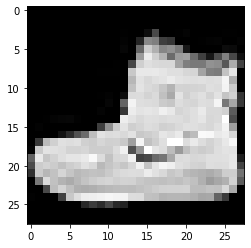

In [6]:
import matplotlib.pyplot as plt
plt.imshow(sample[0],cmap = 'gray')

So to have an idea bout the existig classes in the dataset, I have hard coded them in below.

In [7]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
                   "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In fact , the labels in the dataset are categorical data from 0 to 9 each one idicateng one of the classes. Numer 0 refers to "T_shirt/top", number one to "Trouser" and so on.

For instance, the lable in the example above indicates the number 9 which is refer to the last class "Ankle Boot".

In [8]:
label

9

In [9]:
class_names[label]

'Ankle boot'

To ake the learning process faster, I am going to use the batch ;earning. So I use the DataLoader module in **torch.utils.data** to divide the data ito batches of size 32. It is possible to choose different numbers but 32 is the one that seems ok in our case. Also to improve performance of learning (avoid overfit and underfit), I put the shuffle for my traning data true, which means that after each epoch of training phase, the construction of batches will be differet in the training data. 

In [10]:
from torch.utils.data import DataLoader
train_loader = DataLoader(p_train_set , batch_size=32 , shuffle = True)
valid_loader = DataLoader(valid_set , batch_size=32 , shuffle = False)
test_loader = DataLoader(test_set , batch_size=32 , shuffle = False)

## Model Definition

Ok, now it is time to define the model. I am going to use a sequential neural network with three layers. Sincethe images are of size 28$*$28, the nput size would be **28$*$28**. For the first hidden layer, I am using 300 neurons and for the second one I a going to use 100 neurons and since we have 10 classes, the last layer consists of 10 neurons (for classes one to nine). These parameters are as well as the learning rate are given as below. 

In [11]:
input_size = 28*28
hidden_layer_1 = 300
hidden_layer_2 = 100
output_size = 10
learning_rate = 0.01

The following snippet illustrates the structure of the model that I costruct. In fact, I and used the *Relu* activation function for each layer of the neural network.

In [12]:
class NeuralNet(nn.Module):
    def __init__(self, input_size , hidden_layer_1 , hidden_layer_2 , output_size):
        super().__init__()
        self.l1 = nn.Linear(input_size , hidden_layer_1)
        self.relu1 = nn.ReLU()
        self.l2 = nn.Linear(hidden_layer_1 , hidden_layer_2)
        self.relu2 = nn.ReLU()
        self.l3 = nn.Linear(hidden_layer_2 , output_size)  
        self.dropout = nn.Dropout(0.5)
    def forward(self , X):
        #out = self.dropout1(X)
        out = self.l1(X)
        out = self.relu1(out)
        out = self.dropout(out)
        out = self.l2(out)
        out = self.dropout(out)
        out = self.relu2(out)
        out = self.l3(out)
        return out
    
model = NeuralNet(input_size , hidden_layer_1 , hidden_layer_2 , output_size)        

By typing the name of the model, we can somehow see the summary of the model structure.

In [13]:
model

NeuralNet(
  (l1): Linear(in_features=784, out_features=300, bias=True)
  (relu1): ReLU()
  (l2): Linear(in_features=300, out_features=100, bias=True)
  (relu2): ReLU()
  (l3): Linear(in_features=100, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

The other things that should be specified before starting the training phase, is the loss function and the optimier. Due to the nature of our problem, which is multiple classification, I have chosen the cross entropy loss function, which is available in **torch.nn**. Also to minimize the loss function, I have used the stochastic gradient decsent algoritm as optimizer.

In [14]:
from torch.optim import lr_scheduler
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
#step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 10 , gamma = 0.09)

## Training and Validation

Now we have all the tools to start training. I will do the training using 30 epochs, the number of steps is equal to number of training batches and the total nuber of steps for validation is equal to number of validation batches. Also I have used a dictionary to save some of the metrics like loss and accuracy during the training phase. These metrics can be used to visualize the performance of algorithm.

In [15]:
from collections import defaultdict
num_epochs = 50
total_steps = len(train_loader)
total_steps_valid = len(valid_loader)
dic = defaultdict(list)

In [16]:
for epoch in range(num_epochs):
    n_currect_train = 0
    n_currect_valid = 0
    running_loss_train = 0
    running_loss_val = 0
    model.train()
    
    for i , (images, labels) in enumerate(train_loader):
        images = images.reshape(-1, 28*28)
        #images = images / 255.0
        outputs = model(images)
        loss_train = criterion(outputs , labels)
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        running_loss_train += loss_train
        _, predictions = torch.max(outputs, 1)
        n_currect_train += (predictions == labels).sum().item()
       # wandb.log({'Train Loss': train_loss/train_total})
    loss_train = running_loss_train / len(train_loader)
    print(f"epoch:{epoch}, training loss = {loss_train} , train_accuracy = {n_currect_train/51000}")
    
    #step_lr_scheduler.step()
    model.eval()
    
    with torch.no_grad():
        for i,(images , labels) in enumerate(valid_loader):
           
            images = images.reshape(-1, 28*28)
            #images = images / 255.0
            outputs = model(images)
            loss_val = criterion(outputs, labels)
            running_loss_val += loss_val
            _,predictions = torch.max(outputs, 1)
            n_currect_valid += (predictions == labels).sum().item()
        loss_val = running_loss_val / len(valid_loader)    
        print(f"epoch:{epoch}, validation loss = {loss_val}, val accuracy = {n_currect_valid/9000}")
        dic['train loss'].append(loss_train.item())
        dic['train accuracy'].append(n_currect_train/51000)
        dic['val loss'].append(loss_val.item())
        dic['val accuracy'].append(n_currect_valid/9000)

epoch:0, training loss = 1.0660334825515747 , train_accuracy = 0.6154901960784314
epoch:0, validation loss = 0.6104346513748169, val accuracy = 0.7731111111111111
epoch:1, training loss = 0.6538720726966858 , train_accuracy = 0.7615098039215686
epoch:1, validation loss = 0.5079036355018616, val accuracy = 0.8117777777777778
epoch:2, training loss = 0.5738135576248169 , train_accuracy = 0.7968823529411765
epoch:2, validation loss = 0.4667207896709442, val accuracy = 0.8312222222222222
epoch:3, training loss = 0.5280290246009827 , train_accuracy = 0.8152941176470588
epoch:3, validation loss = 0.43352800607681274, val accuracy = 0.8434444444444444
epoch:4, training loss = 0.4966854155063629 , train_accuracy = 0.8253333333333334
epoch:4, validation loss = 0.4204733073711395, val accuracy = 0.8435555555555555
epoch:5, training loss = 0.47657376527786255 , train_accuracy = 0.8328039215686275
epoch:5, validation loss = 0.4025634527206421, val accuracy = 0.8498888888888889
epoch:6, training lo

Using the information registered in the dictionary, now I can see the performance of the model using loss value and accuracy for both the training set and validation set.

(0.0, 1.0)

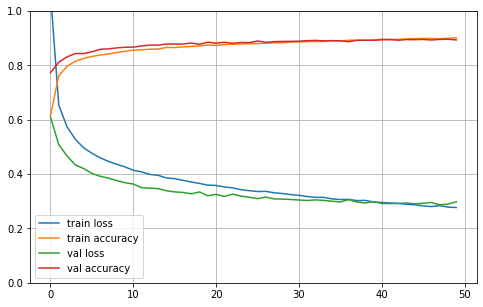

In [17]:
import pandas as pd
pd.DataFrame(dic).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1] plt.show()

## Applying the model on test set

In [18]:
with torch.no_grad():
    n_samples , n_correct = 0,0
    for (images , labels) in test_loader:
        images = images.reshape(-1,28*28)
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        n_samples +=labels.shape[0]
        n_correct +=(labels ==predictions).sum().item()
    print(n_correct/n_samples)   

0.783
